# Utilizzo della libreria Backtester

Questo notebook mostra come utilizzare la libreria di backtesting che abbiamo creato per testare strategie di trading con le Bollinger Bands.

## 1. Importazione delle librerie

In [1]:
# Importa i moduli della libreria backtester
import sys
sys.path.append('/home/edocame/Desktop/bollingerBands')  # Aggiungi il path

from modules.backtester import data_loader, indicators, backtest_engine, visualization, utils
import pandas as pd
import numpy as np

# Importa anche matplotlib per i grafici
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Caricamento e preparazione dei dati

In [2]:
# Carica i dati tick dal file Parquet
file_path = '/media/edocame/HDD_2/data_python/03_BID_ASK_DATA/2025.7.16AUDCAD_oanda-TICK-No Session.parquet'
tick_data = data_loader.load_parquet_data(file_path)


print(f"Dati caricati: {len(tick_data)} righe")
print(f"Periodo: {tick_data.index.min()} - {tick_data.index.max()}")
print(f"Colonne: {tick_data.columns.tolist()}")
print("\nPrime righe:")
print(tick_data.head())

Dati caricati: 402521269 righe
Periodo: 0 - 1469667
Colonne: ['DateTime', 'Bid', 'Ask', 'Volume']

Prime righe:
                                   DateTime      Bid      Ask  Volume
__null_dask_index__                                                  
0                   2006-01-03 02:01:07.588  0.85208  0.85254   12130
1                   2006-01-03 02:01:08.654  0.85213  0.85261   17880
2                   2006-01-03 02:01:08.859  0.85212  0.85266   33260
3                   2006-01-03 02:01:11.472  0.85215  0.85267    2120
4                   2006-01-03 02:01:12.002  0.85218  0.85264   26440


In [5]:
# Rinomina tutte le colonne di minute_data in minuscolo
tick_data.columns = [col.lower() for col in tick_data.columns]
print(f"Colonne rinominate: {tick_data.columns.tolist()}")

Colonne rinominate: ['datetime', 'bid', 'ask', 'volume']


In [6]:
# Assicurati che la colonna 'datetime' sia di tipo datetime e impostala come indice
if not pd.api.types.is_datetime64_any_dtype(tick_data['datetime']):
    tick_data['datetime'] = pd.to_datetime(tick_data['datetime'], errors='coerce')
    print('Colonna datetime convertita in datetime.')
else:
    print('Colonna datetime già in formato datetime.')

# Imposta la colonna 'datetime' come indice
if tick_data.index.name != 'datetime':
    tick_data = tick_data.set_index('datetime')
    print('Colonna datetime impostata come indice.')
else:
    print('Colonna datetime già impostata come indice.')

# Mostra le prime righe per conferma
print(tick_data.head())

Colonna datetime già in formato datetime.
Colonna datetime impostata come indice.
                             bid      ask  volume
datetime                                         
2006-01-03 02:01:07.588  0.85208  0.85254   12130
2006-01-03 02:01:08.654  0.85213  0.85261   17880
2006-01-03 02:01:08.859  0.85212  0.85266   33260
2006-01-03 02:01:11.472  0.85215  0.85267    2120
2006-01-03 02:01:12.002  0.85218  0.85264   26440


In [7]:
# Prepara i dati a minuto
minute_data = data_loader.prepare_minute_data(tick_data, resample_rule='1T')

print(f"Dati a minuto: {len(minute_data)} righe")
print(f"Periodo: {minute_data.index.min()} - {minute_data.index.max()}")
print("\nPrime righe:")
print(minute_data.head())

Dati a minuto: 6587756 righe
Periodo: 2006-01-03 02:01:00 - 2025-07-16 02:59:00

Prime righe:
                         bid      ask  midprice
datetime                                       
2006-01-03 02:01:00  0.85208  0.85254   0.85231
2006-01-03 02:02:00  0.85219  0.85273   0.85246
2006-01-03 02:03:00  0.85221  0.85267   0.85244
2006-01-03 02:05:00  0.85252  0.85298   0.85275
2006-01-03 02:06:00  0.85273  0.85319   0.85296


In [8]:
del tick_data
import gc
gc.collect()

966

## 3. Calcolo degli indicatori tecnici

In [10]:
# Calcola le Bollinger Bands
window = 1440  # 24 ore = 1440 minuti
num_std_dev = 1.0

data_with_bands = indicators.bollinger_bands(
    minute_data, 
    price_column='midprice',
    window=window, 
    num_std_dev=num_std_dev
)

# Rimuovi le righe con valori NaN
complete_data = data_with_bands.dropna()

print(f"Dati completi per il backtest: {len(complete_data)} righe")
print(f"Colonne disponibili: {complete_data.columns.tolist()}")
print("\nPrime righe con indicatori:")
print(complete_data.head())

Dati completi per il backtest: 6586317 righe
Colonne disponibili: ['bid', 'ask', 'midprice', 'upper_band', 'lower_band', 'middle_band']

Prime righe con indicatori:
                         bid      ask  midprice  upper_band  lower_band  \
datetime                                                                  
2006-01-04 07:01:00  0.85832  0.85880   0.85856    0.857223    0.853493   
2006-01-04 07:03:00  0.85832  0.85876   0.85854    0.857228    0.853498   
2006-01-04 07:04:00  0.85843  0.85889   0.85866    0.857232    0.853501   
2006-01-04 07:05:00  0.85840  0.85886   0.85863    0.857237    0.853505   
2006-01-04 07:06:00  0.85846  0.85900   0.85873    0.857242    0.853509   

                     middle_band  
datetime                          
2006-01-04 07:01:00     0.855358  
2006-01-04 07:03:00     0.855363  
2006-01-04 07:04:00     0.855367  
2006-01-04 07:05:00     0.855371  
2006-01-04 07:06:00     0.855375  


## 4. Esecuzione del backtest

In [11]:
# Crea e esegui il backtest
backtester = backtest_engine.Backtest(complete_data)
results_data = backtester.run()

# Stampa il riassunto delle performance
backtester.print_performance_summary()

=== BACKTEST PERFORMANCE SUMMARY ===
Total Trades: 12194
Total PnL: -10236.20 pips
Average Trade: -0.84 pips
Win Rate: 72.60%
Winning Trades: 8853
Losing Trades: 3308
Best Trade: 184.40 pips
Worst Trade: -1280.00 pips
Maximum Drawdown: 11768.20 pips


## 5. Analisi dei risultati

In [12]:
# Ottieni i risultati come DataFrame
trades_df = backtester.get_trades_dataframe()

if not trades_df.empty:
    print(f"Numero di trade: {len(trades_df)}")
    print("\nPrimi 10 trade:")
    print(trades_df.head(10))
    
    # Statistiche aggiuntive
    win_loss_stats = utils.calculate_win_loss_ratio(trades_df['PnL'])
    print("\nStatistiche Win/Loss:")
    for key, value in win_loss_stats.items():
        print(f"  {key}: {value:.2f}")
else:
    print("Nessun trade eseguito.")

Numero di trade: 12194

Primi 10 trade:
    PnL  Direction  Entry_idx  Exit_idx  Cumulative_PnL           Exit_Time
0  11.1         -1         66       386            11.1 2006-01-04 14:31:00
1  13.8         -1        456       547            24.9 2006-01-04 17:20:00
2  14.1         -1        599       836            39.0 2006-01-04 22:34:00
3   9.7         -1        933       942            48.7 2006-01-05 01:19:00
4   6.8         -1       1004      1036            55.5 2006-01-05 03:08:00
5   2.9          1       1043      1057            58.4 2006-01-05 03:32:00
6   0.6         -1       1074      1088            59.0 2006-01-05 04:06:00
7   8.7         -1       1122      1151            67.7 2006-01-05 05:29:00
8   6.2          1       1200      1219            73.9 2006-01-05 07:18:00
9   6.1          1       1266      1308            80.0 2006-01-05 09:23:00

Statistiche Win/Loss:
  win_rate: 72.60
  loss_rate: 27.13
  avg_win: 9.51
  avg_loss: -28.55
  win_loss_ratio: 0.33
  prof

## 6. Visualizzazione dei risultati

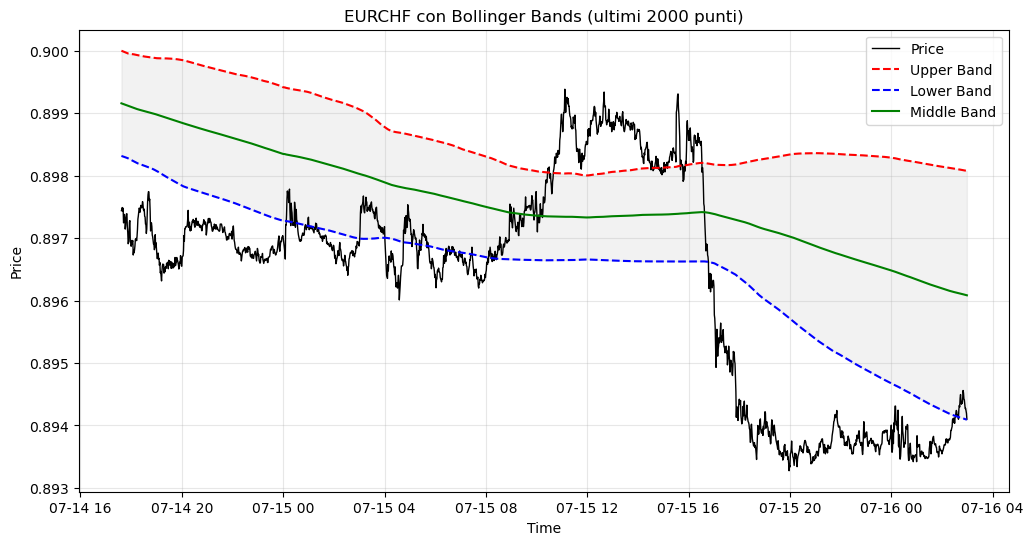

In [13]:
# Visualizza i prezzi con le Bollinger Bands
# Prendi un subset dei dati per una visualizzazione più chiara
subset_data = complete_data.iloc[-2000:]  # Ultimi 2000 punti

visualization.plot_price_with_bollinger_bands(
    subset_data, 
    title="EURCHF con Bollinger Bands (ultimi 2000 punti)"
)

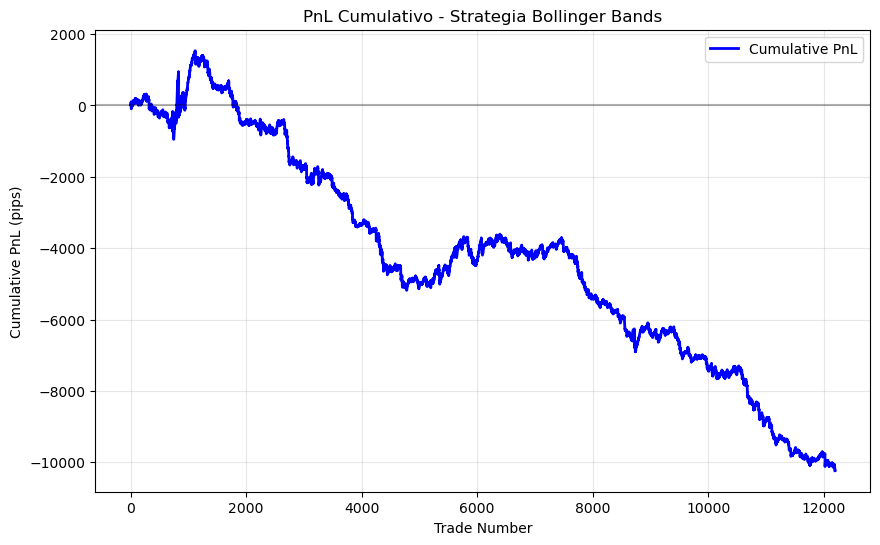

In [14]:
# Visualizza il PnL cumulativo
if not trades_df.empty:
    visualization.plot_cumulative_pnl(
        trades_df, 
        title="PnL Cumulativo - Strategia Bollinger Bands"
    )

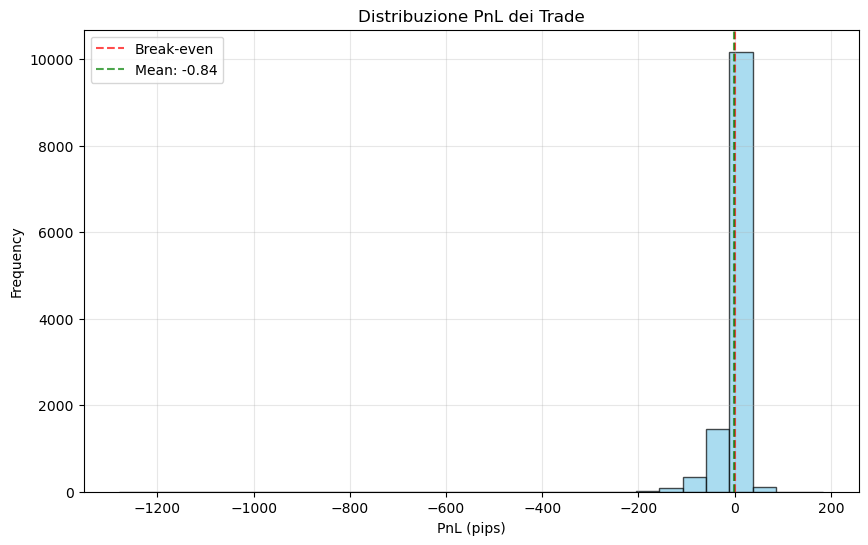

In [15]:
# Visualizza la distribuzione dei trade
if not trades_df.empty:
    visualization.plot_trade_distribution(
        trades_df, 
        title="Distribuzione PnL dei Trade"
    )

## 7. Grafici interattivi (Plotly)

In [16]:
# Grafico interattivo dei prezzi con Bollinger Bands
visualization.plot_interactive_price_bands(
    subset_data, 
    title="EURCHF con Bollinger Bands - Grafico Interattivo"
)

In [17]:
# Grafico interattivo del PnL cumulativo
if not trades_df.empty:
    visualization.plot_interactive_cumulative_pnl(
        trades_df, 
        title="PnL Cumulativo - Grafico Interattivo"
    )

## 9. Dashboard completo

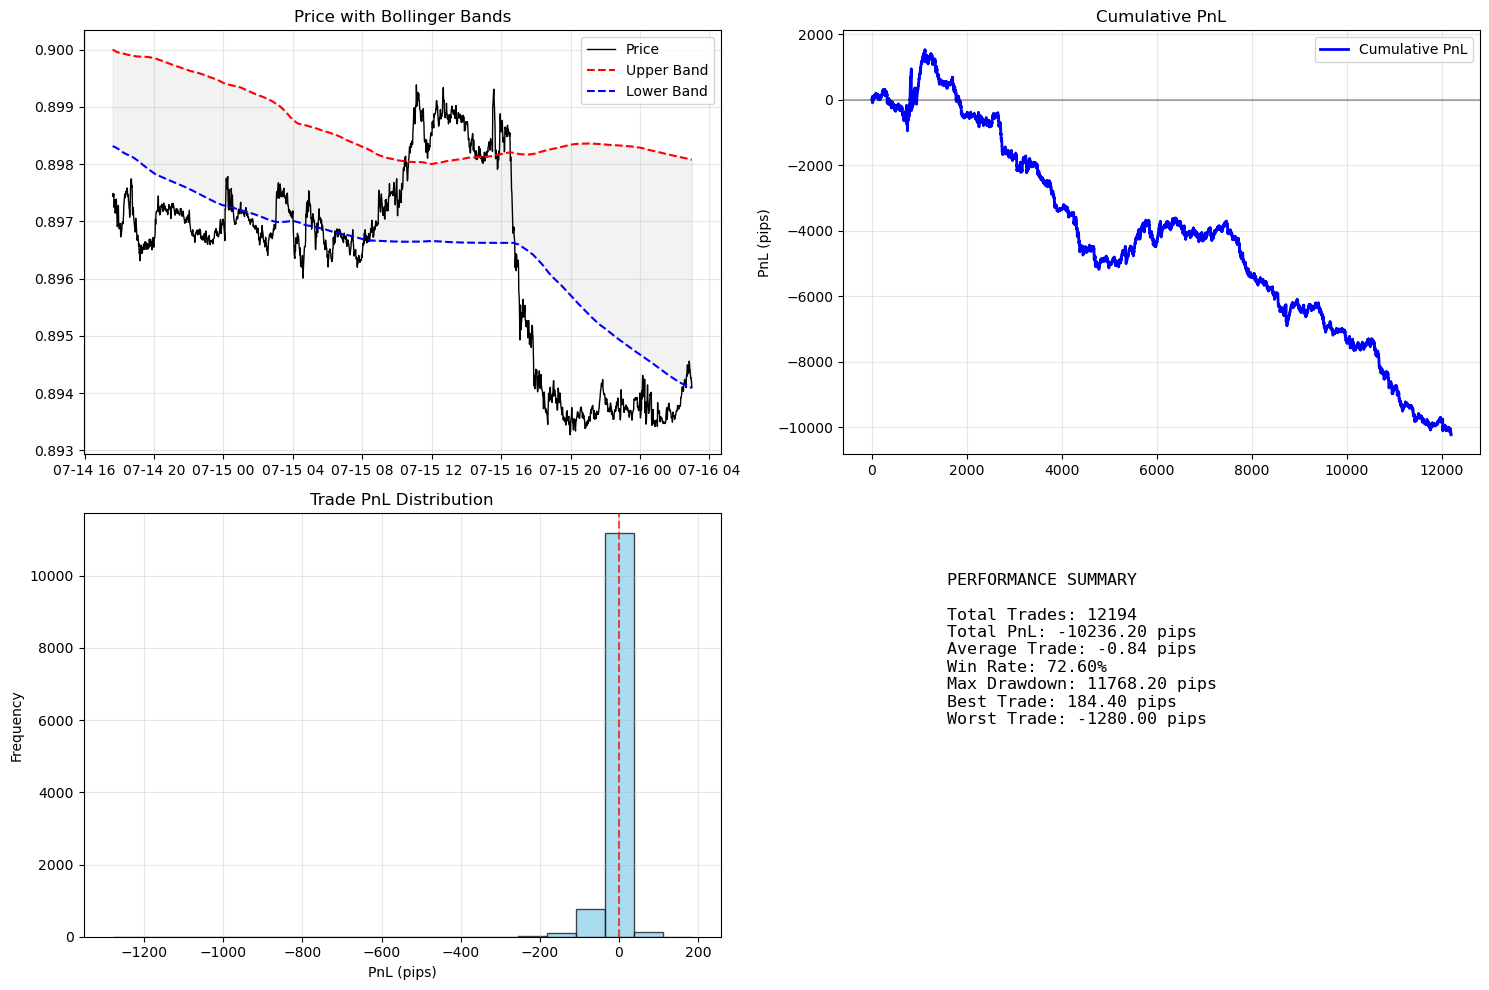

In [19]:
# Crea un dashboard completo con tutti i grafici
if not trades_df.empty:
    visualization.create_performance_dashboard(
        subset_data, 
        trades_df, 
        backtester.performance_metrics
    )

## 10. Test con parametri diversi

In [20]:
# Forza il reload del modulo per assicurarsi che le nuove funzioni siano disponibili
import importlib
import sys

# Reload del modulo backtest_engine per caricare le nuove funzioni
if 'backtester.backtest_engine' in sys.modules:
    importlib.reload(sys.modules['backtester.backtest_engine'])

# Importa le funzioni di ottimizzazione dal backtest_engine
from modules.backtester.backtest_engine import optimize_parameters, plot_top_equity_curves

# Esegui l'ottimizzazione dei parametri con multiprocessing
print("Avvio ottimizzazione parametri...")
parameter_results = optimize_parameters(
    minute_data=minute_data,
    window_start=60,
    window_stop=14400,
    window_step=60,
    std_start=0.2,
    std_stop=4.0,
    std_step=0.2,
    price_column='midprice'
)

# Mostra i risultati completi
print("\n=== TUTTI I RISULTATI ===")
print(parameter_results.to_string(index=False))

# Plotta le top 5 equity curves usando la funzione dedicata
print("\nGenerazione grafici delle migliori equity curves...")
plot_top_equity_curves(
    results_df=parameter_results,
    minute_data=minute_data,
    top_n=5,
    price_column='midprice'
)

Avvio ottimizzazione parametri...
Starting optimization with 4800 parameter combinations...
Using 16 cores for parallel computation.


Parameter optimization:   1%|▏         | 63/4800 [00:25<29:44,  2.66it/s] Process ForkProcess-9:
Process ForkProcess-11:
Process ForkProcess-14:
Parameter optimization:   1%|▏         | 63/4800 [00:26<33:14,  2.38it/s]Exception in thread Thread-8:
Traceback (most recent call last):
  File "/home/edocame/miniconda3/envs/rapids-23.12/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
Process ForkProcess-4:
Process ForkProcess-13:
Process ForkProcess-12:
Process ForkProcess-6:
Process ForkProcess-5:
Process ForkProcess-10:
Process ForkProcess-8:
Process ForkProcess-7:

    self.run()
  File "/home/edocame/miniconda3/envs/rapids-23.12/lib/python3.10/concurrent/futures/process.py", line 323, in run
    self.terminate_broken(cause)
  File "/home/edocame/miniconda3/envs/rapids-23.12/lib/python3.10/concurrent/futures/process.py", line 463, in terminate_broken
    work_item.future.set_exception(bpe)
  File "/home/edocame/miniconda3/envs/rapids-23.12/lib/python3.10/concurrent/futures/_

KeyboardInterrupt: 

## Walk forward opt

In [ ]:
# Crea un subset di minute_data in base a start_date e end_date
start_date = '2023-01-01'
end_date = '2025-07-05'
subset_df = minute_data.loc[start_date:end_date]

print(f"Subset creato: {len(subset_df)} righe")
print(f"Periodo: {subset_df.index.min()} - {subset_df.index.max()}")
print(subset_df.head())

In [ ]:
# Force reload of the modules to ensure latest changes are loaded
import importlib
import sys

# Reload all backtester modules
modules_to_reload = [
    'modules.backtester.walk_forward',
    'modules.backtester.backtest_engine',
    'modules.backtester.indicators',
    'modules.backtester.data_loader',
    'modules.backtester.visualization',
    'modules.backtester.utils'
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        importlib.reload(sys.modules[module_name])

# Re-import the walk forward functions with the fixes
from modules.backtester.walk_forward import walk_forward_optimization, plot_wfo_results

# Execute Walk Forward Optimization with proper error handling
try:
    print("Starting Walk Forward Optimization...")
    wfo_results = walk_forward_optimization(
        minute_data=subset_df,
        lookback_days=180,  # Use 10 days of data for optimization
        optimization_interval_days=5,  # Re-optimize every 5 days
        window_start=400,
        window_stop=8000,
        window_step=1000,
        std_start=0.5,
        std_stop=6.0,
        std_step=0.5,
        price_column='midprice'
    )
    
    # Plot and analyze results
    plot_wfo_results(wfo_results)
    
except Exception as e:
    print(f"Error during Walk Forward Optimization: {e}")
    import traceback
    traceback.print_exc()
    print("Please check your data and parameters.")